In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)

True
cuda


In [2]:
# Load data
loaded_trajectory_pos = np.load('trajectory_pos.npy', allow_pickle=True)
N_STEPS = len(loaded_trajectory_pos)
NUM_PARTICLES = loaded_trajectory_pos[0].shape[0]
LX = 5. # BOX WIDTH
LY = 5.  # BOX HEIGHT
DEG_FREED = 2 # degrees of freedom, here x and y coordinates
NUM_FEATURES = NUM_PARTICLES * DEG_FREED
print('N_STEPS =', N_STEPS)
print('NUM_PARTICLES =', NUM_PARTICLES)
print('DEG_FREED =', DEG_FREED)
print(loaded_trajectory_pos.shape)

N_STEPS = 1001
NUM_PARTICLES = 12
DEG_FREED = 2
(1001, 12, 2)


In [3]:
# Data preparation
#input T0 is the time step t; output T1 the time step t+1
sequence = loaded_trajectory_pos/LX
#all values are betwenn 0 and 1
print(sequence.shape)
print(np.max(sequence))
print(np.min(sequence))

(1001, 12, 2)
0.9998995337032556
5.122800017431927e-06


In [4]:
#Data preparation
sequence_tensor = torch.tensor(sequence, dtype=torch.float32)
print(sequence_tensor.shape)

# Splitting data into training and validation sets
train_size = int(0.8 * len(sequence_tensor))
validation_size = len(sequence_tensor) - train_size
train_dataset, validation_dataset = random_split(sequence_tensor, [train_size, validation_size])

torch.Size([1001, 12, 2])


In [5]:
class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.n_hidden = n_hidden
        self.attn = nn.Linear(self.n_hidden * 2, 1)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        hidden = hidden.repeat(seq_len, 1, 1).transpose(0, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), 2)))
        attention_weights = F.softmax(energy, dim=1)
        context = torch.bmm(attention_weights.transpose(1, 2), encoder_outputs)
        return context

class RNNModel(nn.Module):
    def __init__(self, n_particles, d_freedom, n_hidden):
        super(RNNModel, self).__init__()
        self.particles = n_particles
        self.degrees = d_freedom
        self.features = n_particles * d_freedom
        self.n_hidden = n_hidden
        self.rnn = nn.RNN(input_size=self.features, hidden_size=n_hidden, batch_first=True)
        self.attention = Attention(n_hidden)
        self.fc1 = nn.Linear(in_features=n_hidden, out_features=self.features)

    def forward(self, x):
        seq_len, _, _ = x.size()
        x = x.view(1, seq_len, self.features)
        rnn_out, hidden = self.rnn(x)
        context = self.attention(hidden[-1], rnn_out)
        out = self.fc1(context.squeeze(1))
        out = out.view(1, self.particles, self.degrees)
        return out

In [6]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, n_particles, d_freedom, n_hidden, num_heads):
        super(RNNModel, self).__init__()
        self.particles = n_particles
        self.degrees = d_freedom
        self.features = n_particles * d_freedom
        self.n_hidden = n_hidden
        self.rnn = nn.RNN(input_size=self.features, hidden_size=n_hidden, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=n_hidden, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(in_features=n_hidden, out_features=self.features)

    def forward(self, x):
        seq_len, _, _ = x.size()
        x = x.view(1, seq_len, self.features)
        rnn_out, _ = self.rnn(x)

        # Transpose for multihead attention
        attn_out, _ = self.multihead_attn(rnn_out, rnn_out, rnn_out)
        
        # You might want to use only the last timestep's output or aggregate them differently
        out = self.fc1(attn_out[:, -1, :])
        
        out = out.view(1, self.particles, self.degrees)
        return out

In [7]:
N_HIDDEN = 24
# Create the model and test it
torch.manual_seed(42)
model = RNNModel(NUM_PARTICLES, DEG_FREED, N_HIDDEN, num_heads=3).to(device)
out= model(sequence_tensor.to(device))
print("out shape", out.shape)
print("out", out)

out shape torch.Size([1, 12, 2])
out tensor([[[ 0.0138, -0.2153],
         [-0.0943, -0.1653],
         [ 0.0127,  0.0313],
         [-0.1891,  0.1250],
         [-0.0280,  0.0476],
         [-0.0622,  0.1665],
         [ 0.0640,  0.0253],
         [-0.1104, -0.0724],
         [ 0.1722, -0.0275],
         [-0.1675,  0.0716],
         [-0.0548, -0.1410],
         [ 0.0239, -0.1117]]], device='cuda:0', grad_fn=<ViewBackward0>)


In [8]:
P_STEPS = 3  # Use previous P_STEPS steps for prediction

from torch.utils.data import DataLoader, Subset

def create_batches(data, batch_size):
    # Ensure that the number of batches is such that the last batch has at least P_STEPS time steps
    num_batches = (len(data) - P_STEPS + 1) // batch_size
    batches = [data[i*batch_size:(i+1)*batch_size + P_STEPS - 1] for i in range(num_batches)]
    return batches

# Create batches
batch_size = 50  # Define batch size
batches = create_batches(sequence_tensor, batch_size)

# Shuffle and split indices for training and validation sets
batch_indices = list(range(len(batches)))
np.random.shuffle(batch_indices)
train_indices = batch_indices[:int(0.8 * len(batch_indices))]
val_indices = batch_indices[int(0.8 * len(batch_indices)):]

# Construct training and validation datasets
train_data = torch.cat([batches[i] for i in train_indices], dim=0)
validation_data = torch.cat([batches[i] for i in val_indices], dim=0)

# DataLoader for training and validation sets
train_loader = DataLoader(train_data, batch_size=batch_size)
validation_loader = DataLoader(validation_data, batch_size=batch_size)

print(train_data.shape)
print(validation_data.shape)

torch.Size([780, 12, 2])
torch.Size([208, 12, 2])


In [9]:
# Define hyperparameters
learning_rate = 0.005
# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
i=100
input_seq = torch.cat([train_data[i-P_STEPS:i]], dim=0)
print(input_seq.shape)

torch.Size([3, 12, 2])


In [11]:
# Training loop
num_epochs = 200
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0.

    for batch in train_loader:
        # Move the batch to the device
        batch = batch.to(device)

        # Zero the gradients at the start of a new batch
        optimizer.zero_grad()

        # Iterate through each time step in the batch, starting from P_STEPS
        for i in range(P_STEPS, len(batch)):
            # Prepare the input and target data for this time step
            input_seq = torch.cat([batch[i-P_STEPS:i]], dim=0)
            target_seq = batch[i].unsqueeze(0)

            # Forward pass
            predicted_seq = model(input_seq)

            # Compute the loss
            loss = loss_fn(predicted_seq, target_seq)
            total_train_loss += loss.item()

            # Accumulate gradients
            loss.backward()

        # Optimization step after processing the entire batch
        optimizer.step()

    # Append loss
    training_losses.append(total_train_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.
    with torch.no_grad():
        for batch in validation_loader:
            # Move the batch to the device
            batch = batch.to(device)

            # Iterate through each time step in the batch
            for i in range(P_STEPS, len(batch)):
                # Prepare input and target sequences from validation batch
                input_seq = torch.cat([batch[i-P_STEPS:i]], dim=0)
                target_seq = batch[i].unsqueeze(0)

                # Forward pass
                predicted_seq = model(input_seq)

                # Compute the loss
                val_loss = loss_fn(predicted_seq, target_seq)
                total_val_loss += 5.*val_loss.item()

    #Append loss
    validation_losses.append(total_val_loss)

    # Print losses for monitoring
    if epoch % ((num_epochs+1)//10) == 0:
        print(f"Epoch: {epoch} | Train loss: {total_train_loss:.4f} | Val loss: {total_val_loss:.4f}")


Epoch: 0 | Train loss: 113.9048 | Val loss: 65.3495
Epoch: 20 | Train loss: 8.5979 | Val loss: 14.9236
Epoch: 40 | Train loss: 6.0494 | Val loss: 8.7831
Epoch: 60 | Train loss: 4.9813 | Val loss: 8.2928
Epoch: 80 | Train loss: 4.1221 | Val loss: 6.6253
Epoch: 100 | Train loss: 3.9387 | Val loss: 5.2743
Epoch: 120 | Train loss: 4.2873 | Val loss: 5.5418
Epoch: 140 | Train loss: 5.4514 | Val loss: 6.0122
Epoch: 160 | Train loss: 4.2271 | Val loss: 5.3542
Epoch: 180 | Train loss: 4.3411 | Val loss: 6.8644


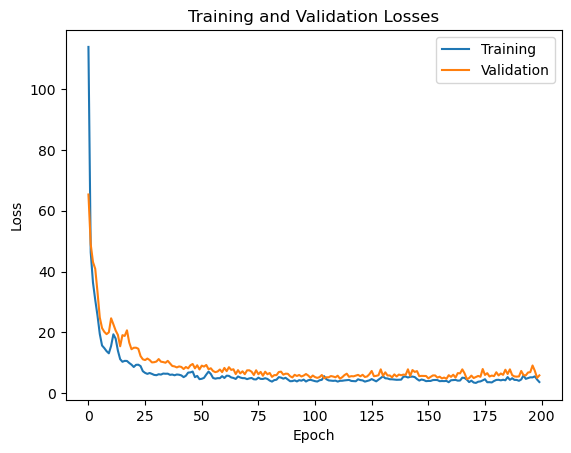

In [12]:
plt.plot(training_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

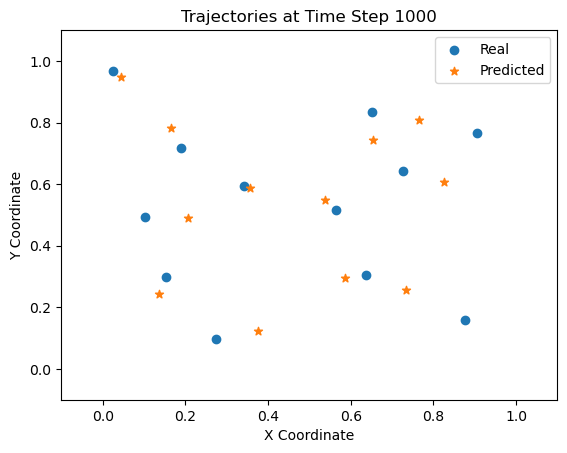

In [13]:
# After training the model, check positions
sequence_tensor = torch.tensor(sequence, dtype=torch.float32).to(device)
predicted_tensor = sequence_tensor.clone().detach()

model.eval()
with torch.no_grad():
    for i in range(P_STEPS, len(sequence_tensor)):
        input_seq = torch.cat([sequence_tensor[i-P_STEPS:i]], dim=0)
        predicted_tensor[i] = model(input_seq)

# Convert to numpy for plotting
real_xy = sequence_tensor.cpu().numpy()
predicted_xy = predicted_tensor.cpu().numpy()

# Visualization for a specific time step
time_step = 1000  # example time step
plt.scatter(real_xy[time_step, :, 0], real_xy[time_step, :, 1], marker='o', label='Real')
plt.scatter(predicted_xy[time_step, :, 0], predicted_xy[time_step, :, 1], marker='*', label='Predicted')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title(f'Trajectories at Time Step {time_step}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def make_video(real_y, pred_y, file_name):
    # Update function for the animation
    def update(frame_number, real_y, pred_y, scatter_real, scatter_pred, time_text):
        # Update the data of both scatter plots for the new frame
        scatter_real.set_offsets(real_y[frame_number])
        scatter_pred.set_offsets(pred_y[frame_number])
        # Update the time annotation
        time_text.set_text(f'Time = {frame_number}')
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    
    # Create initial scatter plots and a text annotation
    scatter_real = ax.scatter(real_y[0, :, 0], real_y[0, :, 1], color='blue', marker='o')
    scatter_pred = ax.scatter(pred_y[0, :, 0], pred_y[0, :, 1], color='orange', marker='*')
    time_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center')
    
    # Create the animation using FuncAnimation
    ani = FuncAnimation(fig, update, frames=len(real_y), fargs=(real_y, pred_y, scatter_real, scatter_pred, time_text), interval=100)
    
    # Save the animation
    ani.save(file_name, writer='ffmpeg')
    
    # Convert the animation to an HTML5 video embedded in the notebook
    html = HTML(ani.to_html5_video())
    
    # Close the figure to prevent it from displaying in the notebook or script output
    plt.close(fig)
    
    # Return the HTML object to display the animation in the notebook
    return html

In [15]:
make_video(real_xy, predicted_xy, file_name = 'predicted_rnnSTEP.mp4')

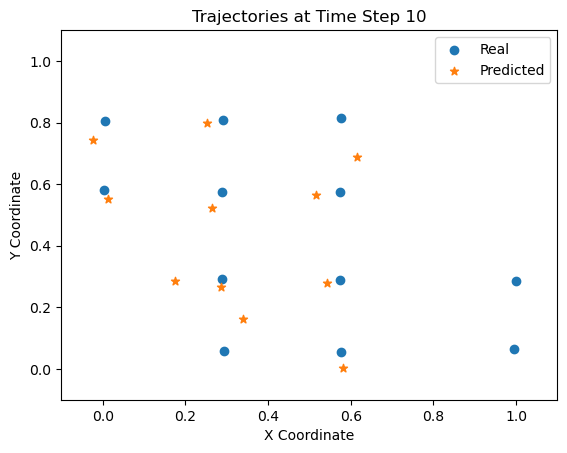

In [16]:
# After training the model, check positions
fully_predicted_tensor = sequence_tensor.clone().detach()

model.eval()
with torch.no_grad():
    for i in range(P_STEPS, len(sequence_tensor)):
        input_seq = torch.cat([fully_predicted_tensor[i-P_STEPS:i]], dim=0)
        fully_predicted_tensor[i] = model(input_seq)

# Convert to numpy for plotting
real_xy = sequence_tensor.cpu().numpy()
fully_predicted_xy = fully_predicted_tensor.cpu().numpy()

# Visualization for a specific time step
time_step = 10  # example time step
plt.scatter(real_xy[time_step, :, 0], real_xy[time_step, :, 1], marker='o', label='Real')
plt.scatter(fully_predicted_xy[time_step, :, 0], fully_predicted_xy[time_step, :, 1], marker='*', label='Predicted')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title(f'Trajectories at Time Step {time_step}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

In [17]:
make_video(real_xy, fully_predicted_xy, file_name = 'fully_predicted_rnnSTEP.mp4')

In [18]:
# Calculate squared differences for x and y coordinates
d1 = ((real_xy[:, :, 0] - predicted_xy[:, :, 0])**2) + ((real_xy[:, :, 1] - predicted_xy[:, :, 1])**2)
d2 = ((real_xy[:, :, 0] - fully_predicted_xy[:, :, 0])**2) + ((real_xy[:, :, 1] - predicted_xy[:, :, 1])**2)
# Sum the errors for all particles at each time step
overall_error_per_timestep1 = np.sum(d1, axis=1)
overall_error_per_timestep2 = np.sum(d2, axis=1)

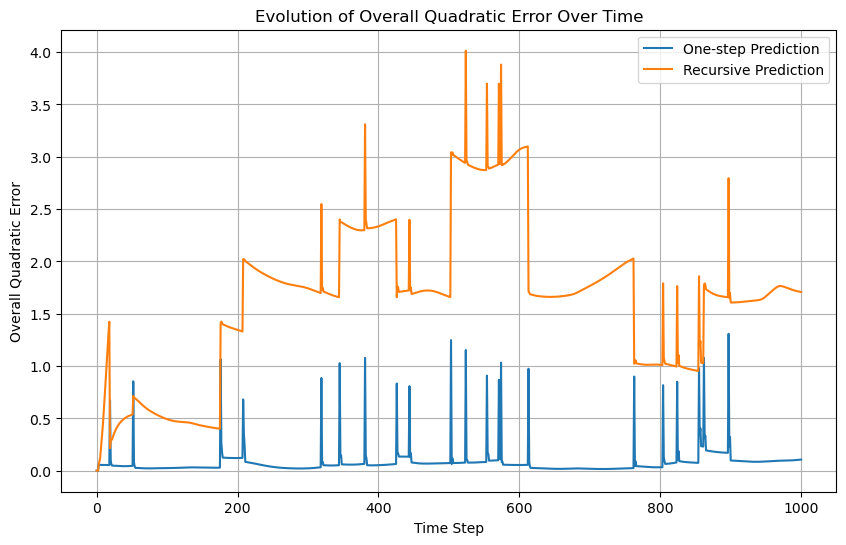

In [19]:
time_steps = np.arange(len(overall_error_per_timestep1))

plt.figure(figsize=(10, 6))
plt.plot(time_steps, overall_error_per_timestep1, label='One-step Prediction')
plt.plot(time_steps, overall_error_per_timestep2, label='Recursive Prediction')
plt.xlabel('Time Step')
plt.ylabel('Overall Quadratic Error')
plt.title('Evolution of Overall Quadratic Error Over Time')
plt.legend()
plt.grid(True)
plt.show()